# Yelp Photo Classifier

This project focuses on developing a sophisticated computer vision system to classify business photos from Yelp into four distinct categories: Food, Drink, Interior, and Exterior. Leveraging deep learning techniques, the project explores various approaches to build and optimize a high-performance image classification model.

If you have trouble in installing tensorflow in your computer, you may consider using Google Colab for this project.

## Part 1 How Yelp Uses Deep Learning to Classify Business Photos?

Yelp hosts tens of millions of photos uploaded by Yelpers from all around the world. The wide variety of these photos provides a rich window into local businesses, a window we’re only just peeking through today.

One way we’re trying to open that window is by developing a photo understanding system which allows us to create semantic data about individual photographs. The data generated by the system has been powering our recent launch of tabbed photo browsing as well as our first attempts at content-based photo diversification.

You can check more details about Yelp's practices at [here](https://engineeringblog.yelp.com/2015/10/how-we-use-deep-learning-to-classify-business-photos-at-yelp.html)


![food](https://engineeringblog.yelp.com/images/posts/2015-10-14-photo-classification/image02.png)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from PIL import Image
keras.backend.clear_session()
tf.random.set_seed(7)
np.random.seed(7)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Let's first upload the file images.npy and labels.npy and load the images dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = np.load('/content/drive/My Drive/Colab Notebooks/Yelp Photo Classifier/images.npy') # SHAPE: (1024, 256, 256, 3) -> (N_SAMPLES, HEIGHT, WIDTH, CHANNELS)
labels = np.load('/content/drive/My Drive/Colab Notebooks/Yelp Photo Classifier/labels.npy') # SHAPE: (1024,) -> (N_SAMPLES,). Label encoded: 0, 1, 2, 3

print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print('Labels match the image at the respective 0 to 1024 position.')

Images shape: (1024, 256, 256, 3)
Labels shape: (1024,)
Labels match the image at the respective 0 to 1024 position.


There are four types of the images on Yelp: Food, Drink, Interior and Exterior

In [ ]:
np.unique(labels)

array([0, 1, 2, 3])

We visualize some random images from the dataset below:

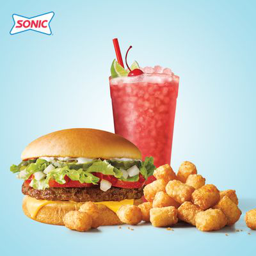

In [ ]:
# food: class 0

Image.fromarray(images[5])

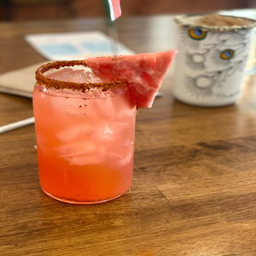

In [ ]:
# drink: class 1

Image.fromarray(images[3])

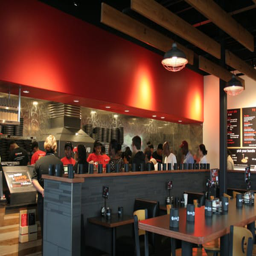

In [ ]:
# interior: class 2

Image.fromarray(images[7])

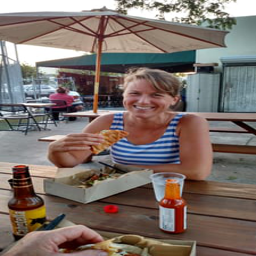

In [ ]:
# exterior: class 3

Image.fromarray(images[8])

### Part 1.1 Training a deep neural network

Practice training a deep neural network on the Yelp image dataset


Build a Deep Neural Network (DNN) with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this question), using the RELU activation function.

Using Adam optimization, train the network on the dataset. Donot forget define your input and output layers.

Train the model for 100 epochs and use test set as the validation data during the training, explain how many parameters does the model have and whether the model will experience overfitting. You may consider plotting the losses and accuracy over epochs.

In [ ]:
# Convert the datasets to a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

# Shuffle the dataset and split into training and validation sets
dataset = dataset.shuffle(buffer_size=len(images), seed=123, reshuffle_each_iteration=False)
train_size = int(0.8 * len(images))  # 80% for training
test_size = len(images) - train_size # 20% for tasting that we will use as validation set

train_d = dataset.take(train_size)
test_d = dataset.skip(train_size)

# Batch and prefetch for performance
batch_size = 32
img_height = 256
img_width = 256

# Batch and prefetch
train_ds = train_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Check one batch of the dataset
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 256, 256, 3)
(32,)


In [ ]:
#Tailoring the learning rate
# Constants
TOTAL_IMAGES = 1024
NUM_EPOCHS = 100
STEPS_PER_EPOCH = TOTAL_IMAGES // batch_size

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.0005,
  decay_steps=STEPS_PER_EPOCH * NUM_EPOCHS,
  decay_rate=0.5,
  staircase=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

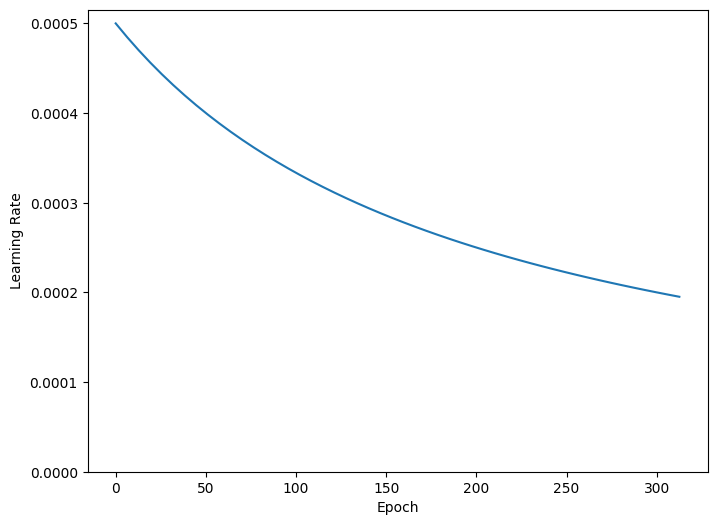

In [ ]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
#Creation of the model
num_classes = len(np.unique(labels))

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
])

model.add(layers.Dense(100, activation='relu'))

for _ in range(19):
    model.add(layers.Dense(100, activation='relu'))

# Output layer for multi-class classification, using softmax
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 196608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │      19,660,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 19,853,204 (75.73 MB)

 Trainable params: 19,853,204 (75.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 613ms/step - accuracy: 0.2466 - loss: 1.3891 - val_accuracy: 0.2195 - val_loss: 1.3884
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 527ms/step - accuracy: 0.2556 - loss: 1.3675 - val_accuracy: 0.3122 - val_loss: 1.3275
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - accuracy: 0.3661 - loss: 1.2564 - val_accuracy: 0.3220 - val_loss: 1.2745
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 514ms/step - accuracy: 0.3626 - loss: 1.2046 - val_accuracy: 0.2878 - val_loss: 1.3649
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - accuracy: 0.4204 - loss: 1.1808 - val_accuracy: 0.3854 - val_loss: 1.2360
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.4619 - loss: 1.1301 - val_accuracy: 0.4146 - val_loss: 1.2350
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 418ms/step - accuracy: 0.4936 - loss: 1.0748 - val_accuracy: 0.4390 - val_loss: 1.2462
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - accuracy: 0.4729 - loss: 1.1237 - 

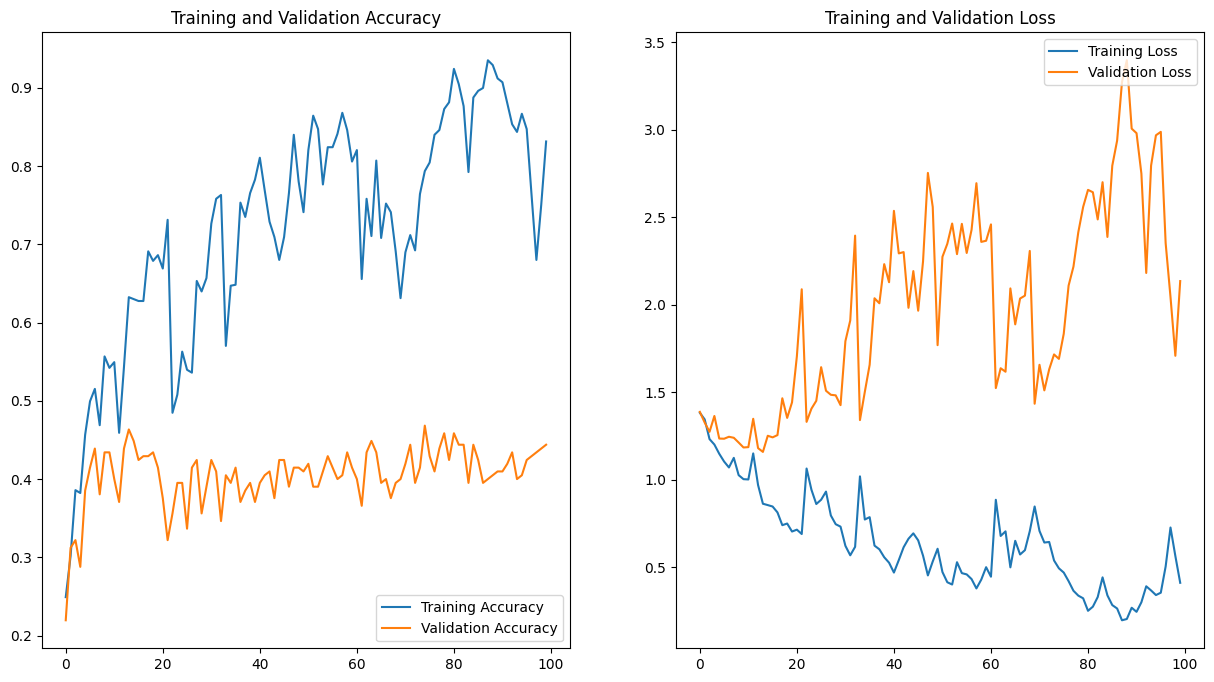

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Basiline Model
test_loss, test_accuracy = model.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Number of parameters:', model.count_params())

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4517 - loss: 2.2140
Test loss: 2.13521146774292
Test accuracy: 0.4439024329185486
Number of parameters: 19853204


### Observations:
The model has 19853204 parameters.

The training and validation plots for the deep neural network, constructed with an excessively deep architecture of 20 hidden layers, manifest clear indications of overfitting. As the training progresses through 100 epochs, we observe that the training accuracy improves steadily, which typically would suggest a model is learning effectively. However, the validation accuracy does not mirror this improvement beyond a certain point, leveling off significantly, a classic hallmark of overfitting. Furthermore, the validation loss exhibits erratic behavior, with marked spikes and an overall lack of a declining trend, underscoring the model's challenges in generalizing to unseen data. The early epochs show promise with both accuracies rising in tandem, but this trend falters as training extends, revealing that while the model is becoming proficient in memorizing the training data, as evidenced by the descending training loss, it fails to sustain this performance on the validation set.

### Part 1.2

Try reduce the overfitting and improve the model performance. You can try the bag of tricks to the model from the class. This may include one or more techniques such as **weight regularization**, **batch normalization**, **dropout**, **Early stopping**, etc. You should perform ``ablation study``, a common techniqued used in machine learning community to show the effectivess of the introduced technique. In other words, show your step-by-step improvement by including these techniques and repeat the repeat the previous training process. Explain whether and how these techniques help achieve a better result. You may consider stopping improving the model by making it at least 10% better than the previous model architecture.

In [ ]:
#Adding early stopping for faster trianing
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [ ]:
#Plotting function
model_histories = {}
def plot_model_histories(model_histories):
    for metric in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
        plt.figure(figsize=(12, 6))
        for model_title, history in model_histories.items():
            plt.plot(history[metric], label=f'{model_title} {metric}')
        plt.title(f'Models {metric.capitalize()}')
        plt.ylabel('Loss' if 'loss' in metric else 'Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()


model_histories['Baseline Model'] = history.history

In [ ]:
#Data Augmentation
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Define data augmentation layers
data_augmentation = Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

# Define the model with data augmentation
augmented_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    *[layers.Dense(100, activation='relu') for _ in range(19)],
    layers.Dense(4, activation='softmax')
])

augmented_model.compile(optimizer=optimizer,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

# Train the model with data augmentation
augmented_history = augmented_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with data augmentation
augmented_test_loss, augmented_test_accuracy = augmented_model.evaluate(test_ds)
print("Data Augmented Model Test Loss:", augmented_test_loss)
print("Data Augmented Model Test Accuracy:", augmented_test_accuracy)

model_histories['Data Augmented Model'] = augmented_history.history

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2552 - loss: 1.3895 - val_accuracy: 0.2195 - val_loss: 1.3809
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 896ms/step - accuracy: 0.3000 - loss: 1.3521 - val_accuracy: 0.3512 - val_loss: 1.3170
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 850ms/step - accuracy: 0.3530 - loss: 1.3346 - val_accuracy: 0.3220 - val_loss: 1.3228
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 866ms/step - accuracy: 0.3736 - loss: 1.2511 - val_accuracy: 0.3366 - val_loss: 1.3221
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 878ms/step - accuracy: 0.3888 - loss: 1.2191 - val_accuracy: 0.3463 - val_loss: 1.2938
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 894ms/step - accuracy: 0.3912 - loss: 1.2555 - val_accuracy: 0.3561 - val_loss: 1.2818
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 822ms/step - accuracy: 0.4526 - loss: 1.1828 - val_accuracy: 0.4585 - val_loss: 1.2413
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 890ms/step - accuracy: 0.4475 - loss: 1.1812 - val

In [ ]:
# Define the model with Dropout
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

dropout_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    *[layers.Dense(100, activation='relu') for _ in range(19)],
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')
])

dropout_model.compile(optimizer= optimizer,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

# Train the model with Dropout
dropout_history = dropout_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with Dropout
dropout_test_loss, dropout_test_accuracy = dropout_model.evaluate(test_ds)
print("Data Dropout Model Test Loss:", dropout_test_loss)
print("Data Dropout Model Test Accuracy:", dropout_test_accuracy)

model_histories['Dropout Model'] = dropout_history.history

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 485ms/step - accuracy: 0.2496 - loss: 1.3848 - val_accuracy: 0.2244 - val_loss: 1.3790
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 419ms/step - accuracy: 0.3189 - loss: 1.3317 - val_accuracy: 0.3171 - val_loss: 1.2982
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 470ms/step - accuracy: 0.3759 - loss: 1.2372 - val_accuracy: 0.3659 - val_loss: 1.3447
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 466ms/step - accuracy: 0.4493 - loss: 1.2296 - val_accuracy: 0.3024 - val_loss: 1.3451
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step - accuracy: 0.3871 - loss: 1.2822 - val_accuracy: 0.3707 - val_loss: 1.2739
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step - accuracy: 0.4100 - loss: 1.1809 - val_accuracy: 0.3805 - val_loss: 1.2370
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - accuracy: 0.4663 - loss: 1.1485 - val_accuracy: 0.4244 - val_loss: 1.2652
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 467ms/step - accuracy: 0.4773 - loss: 1.1199 - 

In [ ]:
# Define the model with batch normalization
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

bn_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
])

# Adding the repeated layers
for _ in range(19):
    bn_model.add(layers.Dense(100, activation='relu'))
    bn_model.add(layers.BatchNormalization())

bn_model.add(layers.Dense(4, activation='softmax'))

bn_model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])

# Train the model
bn_history = bn_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with batch normalization
bn_test_loss, bn_test_accuracy = bn_model.evaluate(test_ds)
print("Batch Normalization Test Loss:", bn_test_loss)
print("Batch Normalization Test Accuracy:", bn_test_accuracy)

model_histories['Batch Norm. Model'] = bn_history.history

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 927ms/step - accuracy: 0.1968 - loss: 1.9245 - val_accuracy: 0.2683 - val_loss: 1.3867
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.2692 - loss: 1.6459 - val_accuracy: 0.2683 - val_loss: 1.3921
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 476ms/step - accuracy: 0.2787 - loss: 1.5781 - val_accuracy: 0.2195 - val_loss: 1.3973
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.3144 - loss: 1.4710 - val_accuracy: 0.2195 - val_loss: 1.4006
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.3274 - loss: 1.4689 - val_accuracy: 0.2488 - val_loss: 1.4072
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.3483 - loss: 1.4408 - val_accuracy: 0.2390 - val_loss: 1.4209
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 463ms/step - accuracy: 0.3435 - loss: 1.3636 - val_accuracy: 0.2537 - val_loss: 1.4311
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step - accuracy: 0.3798 - loss: 1.3611 - 

In [ ]:
# Define the model with weight regularization
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

regularization_model = Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Flatten(),
    layers.Dense(100, activation='relu', kernel_regularizer=l2(0.0001)),
    *[layers.Dense(100, activation='relu', kernel_regularizer=l2(0.0001)) for _ in range(19)],
    layers.Dense(4, activation='softmax')
])

regularization_model.compile(optimizer='adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

# Train the model with weight regularization
regularization_history = regularization_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with weight regularization
regularization_test_loss, regularization_test_accuracy = regularization_model.evaluate(test_ds)
print("Regularization Test Loss:", regularization_test_loss)
print("Regularization Test Accuracy:", regularization_test_accuracy)

model_histories['Regularization Model'] = regularization_history.history

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 649ms/step - accuracy: 0.2133 - loss: 1.5938 - val_accuracy: 0.2732 - val_loss: 1.5491
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 628ms/step - accuracy: 0.2598 - loss: 1.5275 - val_accuracy: 0.2683 - val_loss: 1.5125
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - accuracy: 0.2969 - loss: 1.4824 - val_accuracy: 0.2780 - val_loss: 1.4869
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 649ms/step - accuracy: 0.3296 - loss: 1.4448 - val_accuracy: 0.3366 - val_loss: 1.4433
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 622ms/step - accuracy: 0.3533 - loss: 1.4142 - val_accuracy: 0.3415 - val_loss: 1.4186
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 626ms/step - accuracy: 0.3598 - loss: 1.3793 - val_accuracy: 0.2976 - val_loss: 1.4405
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 626ms/step - accuracy: 0.3983 - loss: 1.3110 - val_accuracy: 0.4049 - val_loss: 1.3534
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - accuracy: 0.4659 - loss: 1.2589 - 

In [ ]:
#Mix model: Data augmentation + Dropout

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define data augmentation layers
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(factor=0.2)
])

# Define the model with data augmentation and dropout
aug_drop_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    *[layers.Dense(100, activation='relu') for _ in range(19)],
    layers.Dropout(0.1),
    layers.Dense(4, activation='softmax')
])

aug_drop_model.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

# Train the model with data augmentation
aug_drop_history = aug_drop_model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=100)

# Evaluate the model with data augmentation and dropout
aug_drop_test_loss, aug_drop_test_accuracy = aug_drop_model.evaluate(test_ds)
print("Data Augmented Dropout Model Test Loss:", aug_drop_test_loss)
print("Data Augmented Dropout Model Test Accuracy:", aug_drop_test_accuracy)

model_histories['Data Aug + Dropout Model'] = aug_drop_history.history

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 978ms/step - accuracy: 0.2643 - loss: 1.4720 - val_accuracy: 0.2244 - val_loss: 1.3880
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 986ms/step - accuracy: 0.2580 - loss: 1.3803 - val_accuracy: 0.2488 - val_loss: 1.3823
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 982ms/step - accuracy: 0.2910 - loss: 1.3671 - val_accuracy: 0.2878 - val_loss: 1.3634
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 946ms/step - accuracy: 0.3146 - loss: 1.3531 - val_accuracy: 0.3366 - val_loss: 1.3383
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 964ms/step - accuracy: 0.3511 - loss: 1.3356 - val_accuracy: 0.3756 - val_loss: 1.3131
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 940ms/step - accuracy: 0.3551 - loss: 1.3045 - val_accuracy: 0.3561 - val_loss: 1.2873
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 991ms/step - accuracy: 0.3948 - loss: 1.2635 - val_accuracy: 0.4195 - val_loss: 1.2368
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 992ms/step - accuracy: 0.4185 - loss: 1.2454 - 

In [ ]:
# Create a dictionary to hold your data
data = {
    "Model": [
        "Baseline",
        "Data Augmented",
        "Dropout",
        "Batch Normalization",
        "Weight Regularization",
        "Data Augmented + Dropout"
    ],
    "Test Loss": [
        test_loss,
        augmented_test_loss,
        dropout_test_loss,
        bn_test_loss,
        regularization_test_loss,
        aug_drop_test_loss
    ],
    "Test Accuracy": [
        test_accuracy,
        augmented_test_accuracy,
        dropout_test_accuracy,
        bn_test_accuracy,
        regularization_test_accuracy,
        aug_drop_test_accuracy
    ]
}

# Create the DataFrame
results_df = pd.DataFrame(data)

results_df.sort_values(by="Test Loss", ascending=True, inplace=True)

# Display the DataFrame
print(results_df)

                      Model  Test Loss  Test Accuracy
1            Data Augmented   1.109757       0.507317
5  Data Augmented + Dropout   1.140005       0.502439
2                   Dropout   1.177129       0.448780
4     Weight Regularization   1.305574       0.390244
3       Batch Normalization   1.307196       0.404878
0                  Baseline   2.135211       0.443902


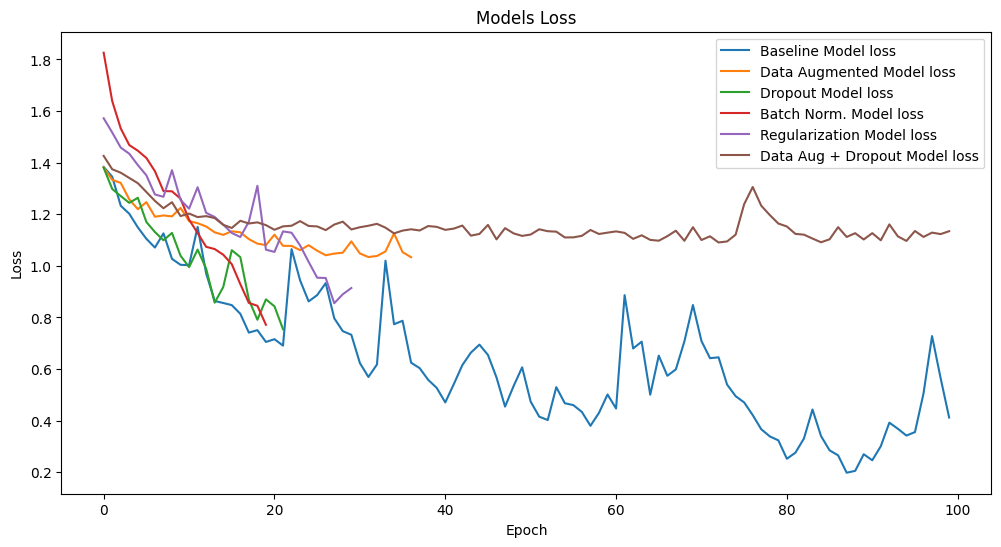

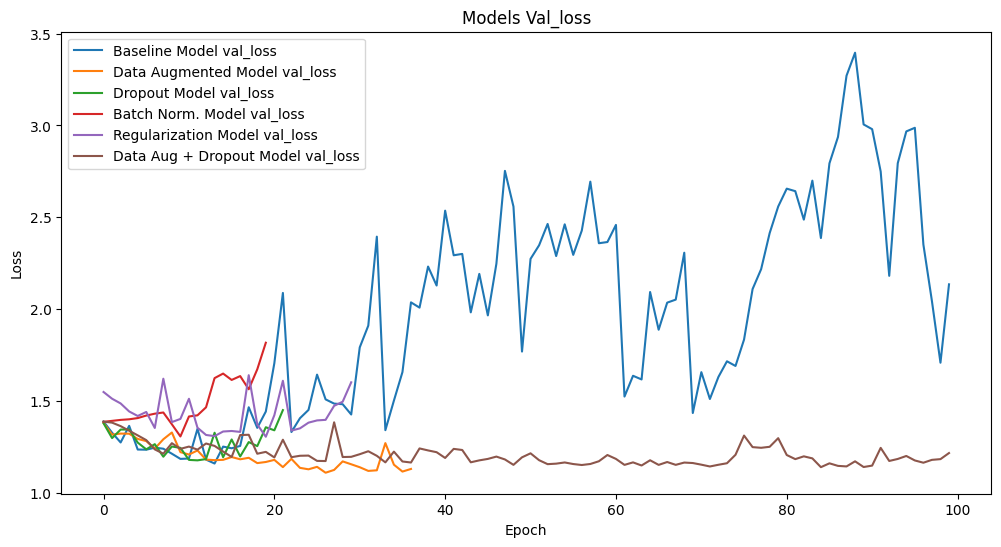

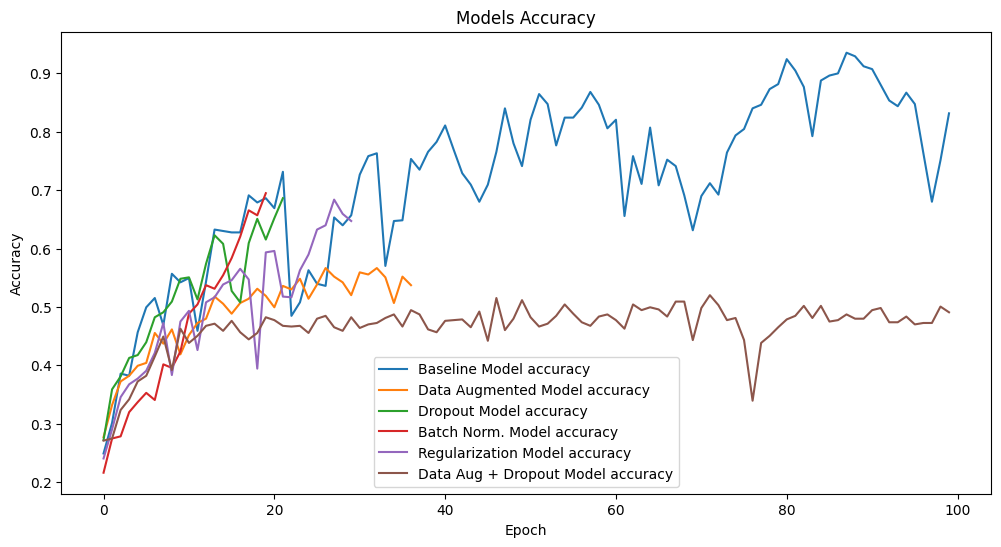

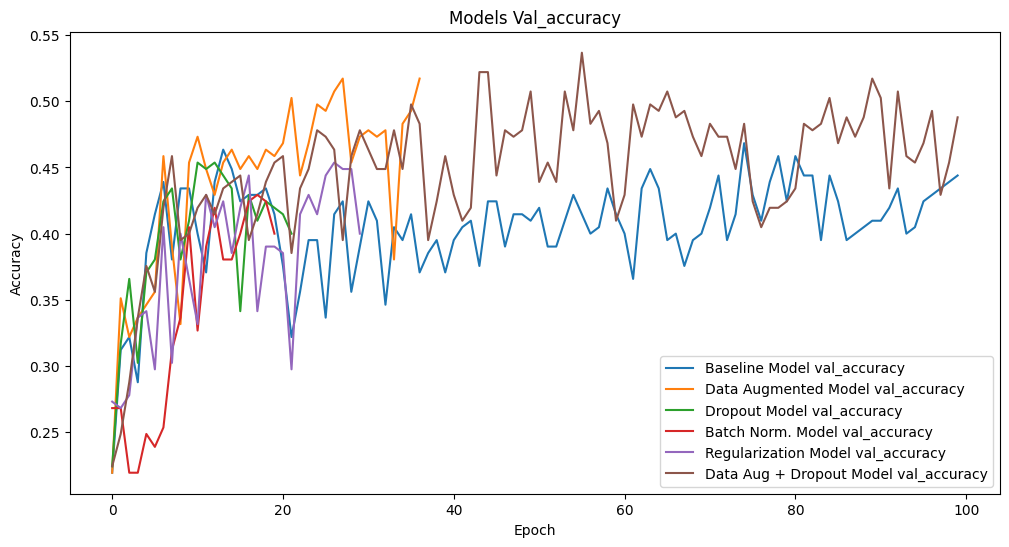

In [ ]:
# Call the plotting function
plot_model_histories(model_histories)

### Observations

The baseline model, with the highest test loss (2.14) and lowest accuracy (44.39%), showed substantial improvement when data augmentation was introduced. Test accuracy increased to 50.73%, highlighting the effectiveness of augmenting training data to enhance model generalization. This added variance likely helped the model better adapt to unseen examples.

The use of early stopping across all models was a strategic addition, serving as a safeguard against overfitting. By halting training once validation performance plateaued, it functioned as a regularization method that preserved model generalization without overtraining on noise.

Combining data augmentation with dropout yielded slightly lower accuracy (50.24%) compared to using data augmentation alone, a somewhat surprising outcome. Although dropout is generally effective in preventing overfitting by limiting neuron co-adaptations, its impact can be counterproductive if too aggressive or if the model's capacity is relatively low.

Dropout on its own led to a modest improvement over the baseline (44.88% vs. 44.39%), but it still underperformed relative to data augmentation. This indicates that while dropout adds robustness by discouraging over-reliance on specific neurons, it may not be as impactful as introducing varied training examples.

Weight regularization offered even less benefit, resulting in just 39.02% accuracy. While regularization typically encourages simpler, more generalizable models by penalizing large weights, it may not have aligned well with the structure or complexity of the dataset.

Batch normalization was the least effective technique, improving neither accuracy nor loss significantly (40.49% accuracy). Although it's often used to stabilize training and accelerate convergence, in this case, it did little to mitigate overfitting or enhance model performance.

In summary, **data augmentation alone proved to be the most beneficial technique**, significantly improving generalization performance, while other methods like dropout and regularization had more limited or mixed results.

### Part 1.3 Convolutional Neural Network

Now, let's define the Convolutional Neural Network.

Define a CNN that is composed of:
- a Conv2D layer with 32 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (2, 2)
- a Conv2D layer with 64 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (2, 2)
- a Conv2D layer with 128 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (3, 3)
- a Flatten layer
- a dense function with 120 neurons with the `relu` activation function
- a dense function with 60 neurons with the `relu` activation function
- a dropout layer (with a rate of 0.5), to regularize the network
- a dense function related to your task

Estimate the model and report your test accuracy. Is it better than the multi-layer perceptron.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)

In [ ]:
conv_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size= 2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size= 2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size= 3),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(60, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

conv_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

conv_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 120)                 │       6,773,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 60)                  │           7,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 4)                   │             244 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,874,632 (26.22 MB)

 Trainable params: 6,874,632 (26.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 15
history = conv_model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

# Evaluate the model with data augmentation and dropout
conv_test_loss, conv_test_accuracy = conv_model.evaluate(test_ds)
print("CNN Model Test Loss:", conv_test_loss)
print("CNN Model Test Accuracy:", conv_test_accuracy)

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.2688 - loss: 1.3924 - val_accuracy: 0.4341 - val_loss: 1.3326
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.4274 - loss: 1.2800 - val_accuracy: 0.4634 - val_loss: 1.2244
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.4780 - loss: 1.1452 - val_accuracy: 0.5415 - val_loss: 1.1306
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.5252 - loss: 1.0885 - val_accuracy: 0.5268 - val_loss: 1.1039
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.5863 - loss: 1.0007 - val_accuracy: 0.5220 - val_loss: 1.0732
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.6297 - loss: 0.9483 - val_accuracy: 0.5220 - val_loss: 1.0514
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.6138 - loss: 0.9347 - val_accuracy: 0.5220 - val_loss: 1.0716
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.6239 - loss: 0.9238 - val_accuracy: 0.5366 - v

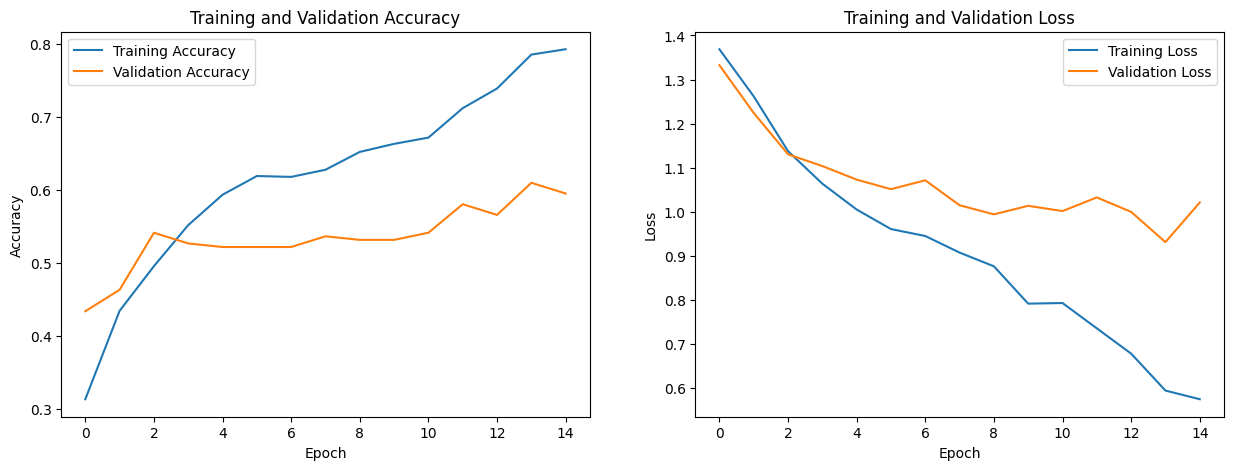

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(15, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Observations

The implementation of a Convolutional Neural Network (CNN) with tailored architecture for image classification markedly improved the model's performance over the previous multi-layer perceptron (MLP). The CNN model achieved a test accuracy of 0.6097, which surpasses the MLP's accuracy, highlighting the CNN's enhanced capability to recognize and utilize spatial hierarchies and features in image data. This effectiveness is bolstered by layers specifically designed for image processing tasks, alongside dropout regularization that effectively reduces overfitting, leading to a more robust model.

### Part 1.4 Transfer learning

In this section, we utilize several well-known deep learning architectures that have been pretrained on ImageNet, a large-scale database containing diverse image categories. These architectures have already learned useful features, or kernels, from the ImageNet dataset that can be repurposed for different tasks.

#### Overview of Transfer Learning Approach

The key idea behind transfer learning is that the early layers of a convolutional neural network (CNN) are not task-specific; they extract general features such as edges, textures, and shapes. These general features are applicable to a wide range of tasks. Therefore, we can leverage these pretrained models by keeping the early layers (which are considered general feature extractors) and fine-tuning the later layers to adapt to a specific task—in this case, classifying different types of flowers.

#### Implementation Steps

1. **Loading Pretrained Models**:
   - We use `tensorflow.keras.applications` to load pretrained models such as VGG16, Inception, ResNet, MobileNet, and EfficientNet.
   - The weights are loaded from the `imagenet` dataset.
   - The input shape is adjusted to match the specific requirements of our image dataset.
   - The `include_top` argument is set to `False` to exclude the fully connected layers that are specific to ImageNet classification, allowing us to add our own custom layers.

2. **Freezing the Pretrained Layers**:
   - The initial layers of the pretrained model are set to non-trainable by applying `model.trainable = False`. This ensures that these layers retain the feature extraction capabilities learned from ImageNet.

3. **Customizing the Model**:
   - After the pretrained layers, we add new layers specific to our classification task. This typically involves:
     - A flattening layer to convert the 2D feature maps into a 1D feature vector.
     - Dense layers to perform the classification. The first dense layer might have 500 neurons, followed by additional dense layers.
     - A final prediction layer that outputs the classification results.

   Example model structure:
   ```python
   model = tf.keras.Sequential([
     base_model,
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(500, activation='relu'),
     tf.keras.layers.Dense(num_classes, activation='softmax')
   ])
   ```

4. **Training and Evaluation**:
   - The model is trained on the flower classification task, and its performance is evaluated based on accuracy and loss.
   - The effectiveness of transfer learning is analyzed by comparing the performance of this model with models that do not use transfer learning.

5. **Comparative Analysis of Models**:
   - We compare the performance and running time of different pretrained models (VGG16, Inception, ResNet, MobileNet, EfficientNet) to determine which architecture is most effective for the flower classification task.
   - The results are discussed to identify the best model in terms of accuracy, speed, and resource efficiency.

In [ ]:
num_classes = 4
new_img_height = 224
new_img_width = 224

def encode_labels(label):
    return tf.one_hot(label, depth=num_classes)

def resize_images(image):
    return tf.image.resize(image, [new_img_height, new_img_width])

# Preprocessing function that combines resizing and label encoding
def preprocess(image, label):
    image = resize_images(image)
    label = encode_labels(label)
    return image, label

train_d = train_d.map(preprocess)
test_d = test_d.map(preprocess)

batch_size = 64

train_ds = train_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_d.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Check one batch of the dataset
for image_batch, labels_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

Image batch shape: (64, 224, 224, 3)
Labels batch shape: (64, 4)


In [ ]:
def load_model(model_name='VGG16', input_shape=(224, 224, 3)):
    if model_name == 'VGG16':
        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'MobileNet':
        base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == 'EfficientNetB0':
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError("Unsupported model name")

    return base_model

def model_trainable(base_model):
    base_model.trainable = False
    base_model.summary()

    return base_model

def modify_model(base_model):
    flattening_layer = tf.keras.layers.Flatten()
    dense_layer = tf.keras.layers.Dense(500, activation='relu')
    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')  # Assuming 5 types of flowers

    model = tf.keras.Sequential([
        base_model,
        flattening_layer,
        dense_layer,
        prediction_layer
    ])

    return model

def compile_and_train_model(model, train_data, val_data, epochs=10):
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    start_time = time.time()
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    training_time = time.time() - start_time
    return history, training_time

def evaluate_model(model, test_data):
    return model.evaluate(test_data)

results = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss', 'Training Time'])

def add_results(model_name, history, evaluation, training_time):
    global results
    last_epoch = history.history['val_accuracy'][-1]
    loss = evaluation[0]
    accuracy = evaluation[1]
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Loss': [loss],
        'Training Time': [training_time]
    })
    results = pd.concat([results, new_row], ignore_index=True)

In [ ]:
#Plotting the models
models_histories = {}
def plot_model_histories(model_histories):
    for metric in ['loss', 'val_loss', 'accuracy', 'val_accuracy']:
        plt.figure(figsize=(12, 6))
        for model_title, history in model_histories.items():
            plt.plot(history[metric], label=f'{model_title} {metric}')
        plt.title(f'Models {metric.capitalize()}')
        plt.ylabel('Loss' if 'loss' in metric else 'Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()


models_histories['Conv Model'] = history.history

In [ ]:
#VGG16
vgg16_model = load_model()
vgg16_model = model_trainable(vgg16_model)
vgg16_model = modify_model(vgg16_model)

history_vgg16_model, training_time_vgg16 = compile_and_train_model(vgg16_model, train_ds, test_ds)
evaluation_vgg16 = evaluate_model(vgg16_model, test_ds)
add_results('VGG16', history_vgg16_model, evaluation_vgg16, training_time_vgg16)

models_histories['VGG16'] = history_vgg16_model.history

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 647s 50s/step - accuracy: 0.4934 - loss: 54.6327 - val_accuracy: 0.7902 - val_loss: 13.5400
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 663s 49s/step - accuracy: 0.9123 - loss: 5.3009 - val_accuracy: 0.8829 - val_loss: 5.1242
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 699s 51s/step - accuracy: 0.9732 - loss: 1.1136 - val_accuracy: 0.8634 - val_loss: 4.8496
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 685s 51s/step - accuracy: 0.9951 - loss: 0.0412 - val_accuracy: 0.8976 - val_loss: 4.5074
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 683s 51s/step - accuracy: 1.0000 - loss: 1.4084e-09 - val_accuracy: 0.8878 - val_loss: 4.3866
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 684s 51s/step - accuracy: 1.0000 - loss: 9.8445e-09 - val_accuracy: 0.8927 - val_loss: 4.4110
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 659s 49s/step - accuracy: 1.0000 - loss: 1.6328e-07 - val_accuracy: 0.8927 - val_loss: 4.4229
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 698s 50s/step - accuracy: 1.0000 - loss: 3.1995e-07 

In [ ]:
#InceptionV3
inceptv3_model = load_model('InceptionV3')
inceptv3_model = model_trainable(inceptv3_model)
inceptv3_model = modify_model(inceptv3_model)

history_inceptv3_model, training_time_inceptv3_model = compile_and_train_model(inceptv3_model, train_ds, test_ds)
evaluation_inceptv3_model= evaluate_model(inceptv3_model, test_ds)
add_results('InceptionV3', history_inceptv3_model, evaluation_inceptv3_model, training_time_inceptv3_model)

models_histories['InceptionV3'] = history_inceptv3_model.history

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 111, 111, 32)   │             96 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 109, 109, 32)   │             96 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 109, 109, 64)   │            192 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 54, 54, 80)     │            240 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 52, 52, 192)    │            576 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 167s 12s/step - accuracy: 0.2773 - loss: 1425.8584 - val_accuracy: 0.3463 - val_loss: 369.6678
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 198s 12s/step - accuracy: 0.4251 - loss: 226.2023 - val_accuracy: 0.3707 - val_loss: 142.1010
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 201s 12s/step - accuracy: 0.5281 - loss: 77.8816 - val_accuracy: 0.5073 - val_loss: 61.9013
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 154s 12s/step - accuracy: 0.6460 - loss: 36.4650 - val_accuracy: 0.4537 - val_loss: 71.7928
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 201s 12s/step - accuracy: 0.6705 - loss: 30.7726 - val_accuracy: 0.5512 - val_loss: 52.3142
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 198s 12s/step - accuracy: 0.7247 - loss: 24.7739 - val_accuracy: 0.4634 - val_loss: 71.6317
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 152s 12s/step - accuracy: 0.7308 - loss: 17.7529 - val_accuracy: 0.5659 - val_loss: 35.9581
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 203s 12s/step - accuracy: 0.8490 - loss: 6.8849

In [ ]:
#ResNet50
resnet50_model = load_model('ResNet50')
resnet50_model = model_trainable(resnet50_model)
resnet50_model = modify_model(resnet50_model)

history_resnet50_model, training_time_resnet50_model = compile_and_train_model(resnet50_model, train_ds, test_ds)
evaluation_resnet50_model= evaluate_model(resnet50_model, test_ds)
add_results('ResNet50', history_resnet50_model, evaluation_resnet50_model, training_time_resnet50_model)

models_histories['ResNet50'] = history_resnet50_model.history

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 221s 16s/step - accuracy: 0.6342 - loss: 17.7250 - val_accuracy: 0.8780 - val_loss: 3.7859
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 297s 19s/step - accuracy: 0.9607 - loss: 1.4895 - val_accuracy: 0.9171 - val_loss: 2.5621
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 206s 16s/step - accuracy: 0.9876 - loss: 0.1782 - val_accuracy: 0.9122 - val_loss: 1.8635
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 208s 16s/step - accuracy: 0.9940 - loss: 0.0611 - val_accuracy: 0.9073 - val_loss: 3.0933
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 261s 16s/step - accuracy: 0.9948 - loss: 0.1142 - val_accuracy: 0.9122 - val_loss: 2.7379
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 264s 16s/step - accuracy: 0.9949 - loss: 0.0567 - val_accuracy: 0.9122 - val_loss: 2.9424
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 261s 16s/step - accuracy: 0.9951 - loss: 0.0515 - val_accuracy: 0.9073 - val_loss: 3.3005
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 262s 16s/step - accuracy: 1.0000 - loss: 1.0010e-05 - val_accurac

In [ ]:
#MobileNet
mobilenet_model = load_model('MobileNet')
mobilenet_model = model_trainable(mobilenet_model)
mobilenet_model = modify_model(mobilenet_model)

history_mobilenet_model, training_time_mobilenet_model = compile_and_train_model(mobilenet_model, train_ds, test_ds)
evaluation_mobilenet_model= evaluate_model(mobilenet_model, test_ds)
add_results('MobileNet', history_mobilenet_model, evaluation_mobilenet_model, training_time_mobilenet_model)

models_histories['MobileNet'] = history_mobilenet_model.history

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.3705 - loss: 32.7176 - val_accuracy: 0.6390 - val_loss: 5.3776
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.8095 - loss: 2.0056 - val_accuracy: 0.6439 - val_loss: 4.4010
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.7883 - loss: 1.8156 - val_accuracy: 0.7268 - val_loss: 2.5459
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9267 - loss: 0.5041 - val_accuracy: 0.6732 - val_loss: 3.2197
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.9264 - loss: 0.3593 - val_accuracy: 0.6927 - val_loss: 3.4670
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.9212 - loss: 0.4625 - val_accuracy: 0.6098 - val_loss: 6.3323
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8920 - loss: 0.4646 - val_accuracy: 0.6976 - val_loss: 2.9202
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.9833 - loss: 0.0563 - val_accuracy: 0.7317 - val_loss

In [ ]:
#EfficientNetB0
effnetB0_model = load_model('EfficientNetB0')
effnetB0_model = model_trainable(effnetB0_model)
effnetB0_model = modify_model(effnetB0_model)

history_effnetB0_model, training_time_effnetB0_model = compile_and_train_model(effnetB0_model, train_ds, test_ds)
evaluation_effnetB0_model= evaluate_model(effnetB0_model, test_ds)
add_results('EfficientNetB0', history_effnetB0_model, evaluation_effnetB0_model, training_time_effnetB0_model)

models_histories['EfficientNetB0'] = history_effnetB0_model.history

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling_7[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_8 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_8[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 112s 8s/step - accuracy: 0.7040 - loss: 1.8094 - val_accuracy: 0.9171 - val_loss: 1.6939
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.9694 - loss: 0.3125 - val_accuracy: 0.9268 - val_loss: 1.4027
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.9869 - loss: 0.1357 - val_accuracy: 0.9171 - val_loss: 1.2849
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 8s/step - accuracy: 0.9962 - loss: 0.0058 - val_accuracy: 0.9268 - val_loss: 1.1808
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 1.0000 - loss: 4.0835e-05 - val_accuracy: 0.9268 - val_loss: 1.1553
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.9984 - loss: 0.0039 - val_accuracy: 0.9317 - val_loss: 1.1890
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 1.0000 - loss: 4.6981e-04 - val_accuracy: 0.9366 - val_loss: 1.1945
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 1.0000 - loss: 2.6966e-05 - val_accuracy: 0

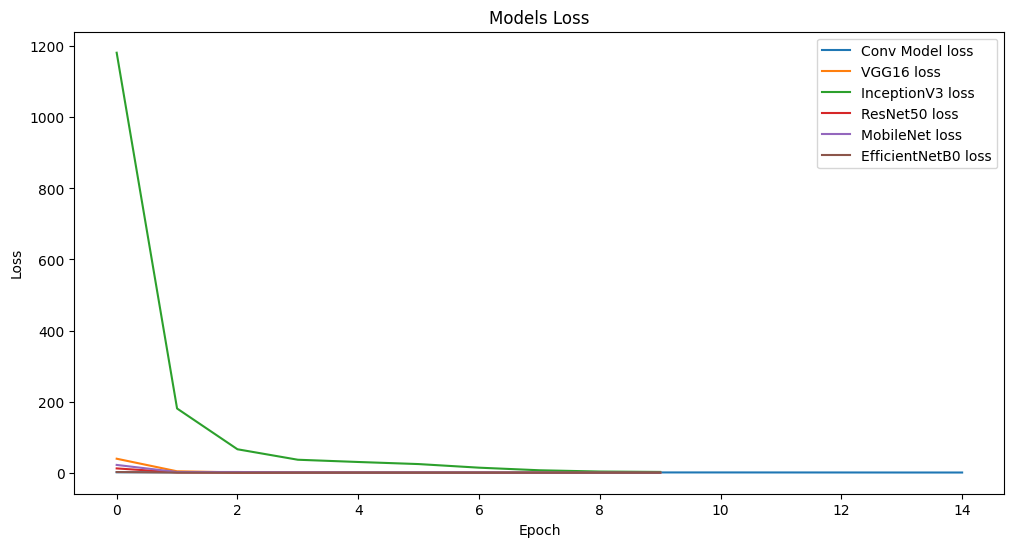

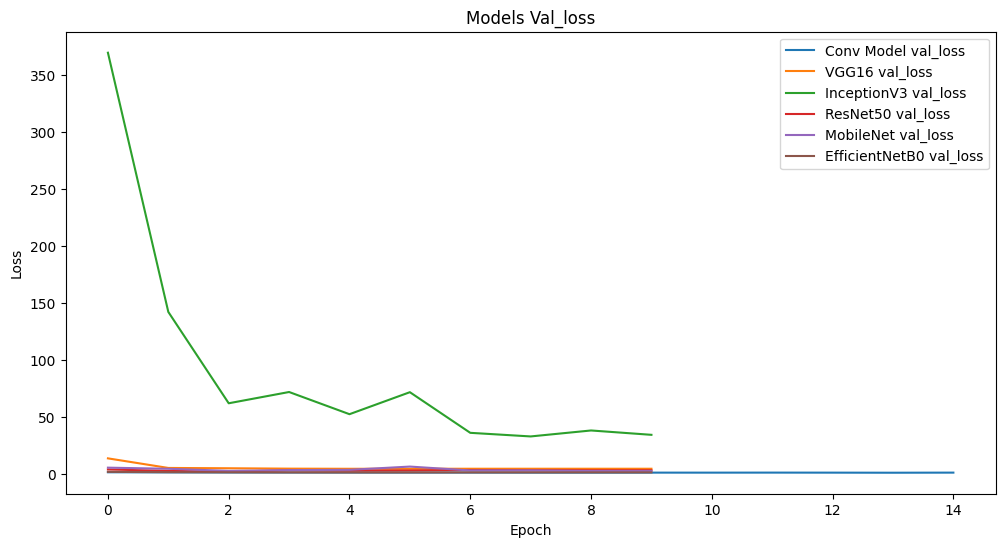

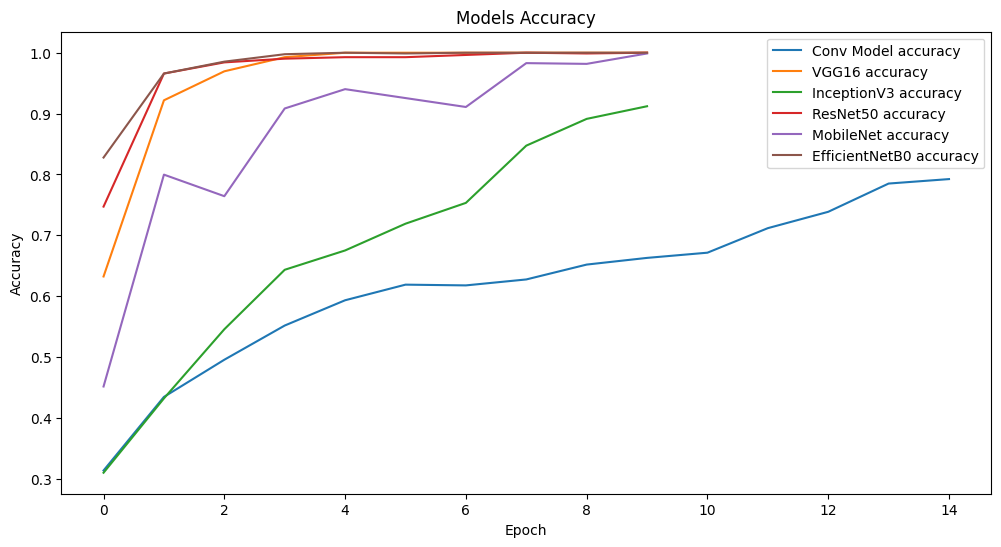

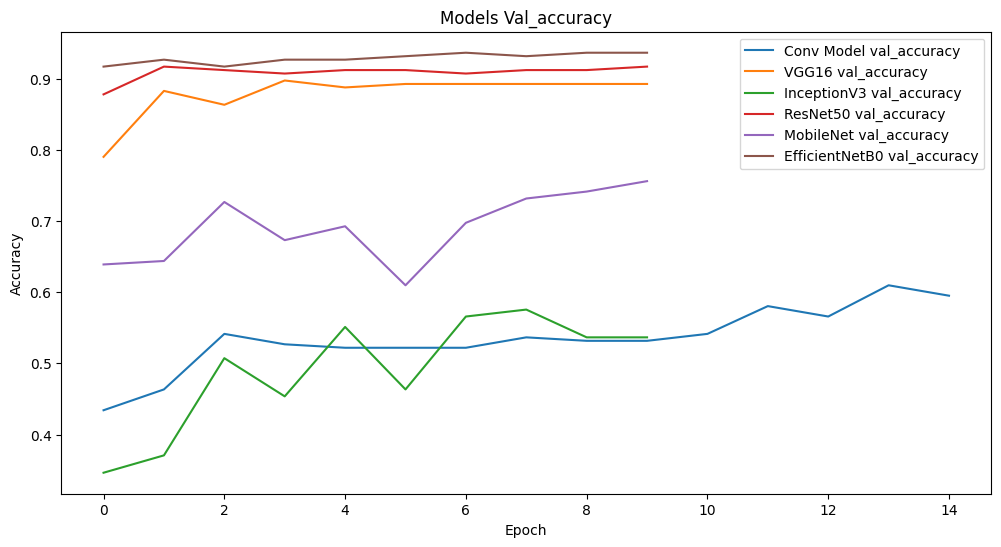

In [ ]:
plot_model_histories(models_histories)

In [ ]:
sorted_results = results.sort_values(by='Accuracy', ascending=False)
print(sorted_results)

            Model  Accuracy       Loss  Training Time
4  EfficientNetB0  0.936585   1.218342    1288.235695
2        ResNet50  0.917073   3.120566    2493.883985
0           VGG16  0.892683   4.427809    6733.267385
3       MobileNet  0.756098   2.338344     697.988083
1     InceptionV3  0.536585  34.201180    1810.002339


EfficientNetB0 emerged as the top-performing model, achieving the highest accuracy of 93.66% with a relatively moderate training time of around 1,288 seconds. This highlights its strength in leveraging transfer learning for effective image classification. ResNet50 followed closely with a strong 91.71% accuracy, although it required nearly twice the training time and had a higher loss, suggesting some overfitting concerns.

VGG16 also performed well, delivering 89.27% accuracy, but at the cost of the longest training time—over 6,700 seconds—making it less ideal for time-sensitive applications. MobileNet stood out for its efficiency, training the fastest at under 700 seconds while maintaining a decent accuracy of 75.61%, positioning it as a solid choice when speed and resource constraints are key factors.

On the other hand, InceptionV3 struggled significantly, reaching only 53.66% accuracy and exhibiting a high loss of 34.20. These results suggest potential issues with model fit or data preprocessing that warrant further investigation.

Overall, the findings underscore the diverse trade-offs among pre-trained models: EfficientNetB0 excels in accuracy, MobileNet in speed, and ResNet50 offers a balance with high accuracy but higher computational cost.